In [23]:
import kagglehub
path = kagglehub.dataset_download("simranvolunesia/pest-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'pest-dataset' dataset.
Path to dataset files: /kaggle/input/pest-dataset


In [24]:
import os
train_dir=path + "/pest/train"
test_dir=path + "/pest/test"
print(os.listdir(train_dir))
print(os.listdir(test_dir))

['beetle', 'mites', 'grasshopper', 'sawfly', 'stem_borer', 'mosquito', 'armyworm', 'aphids', 'bollworm']
['beetle', 'mites', 'grasshopper', 'sawfly', 'stem_borer', 'mosquito', 'armyworm', 'aphids', 'bollworm']


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob as gb
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense ,Conv2D ,Dropout ,BatchNormalization , GlobalAveragePooling2D, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau , ModelCheckpoint
from keras.applications.mobilenet import MobileNet ,preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


In [26]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 20

Loading sample image from: /kaggle/input/pest-dataset/pest/train/beetle/jpg_76 - Copy (3).jpg


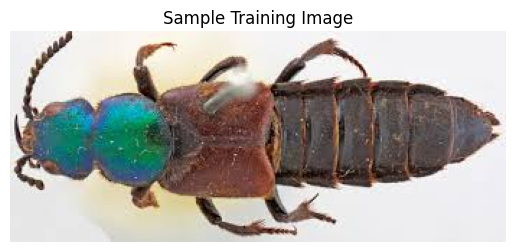

Image shape: (146, 344, 3)


In [ ]:
try:
    sample_image_path = gb.glob(os.path.join(train_dir, '*/*.jpg'))[0]

    print(f"Loading sample image from: {sample_image_path}")
    img = cv2.imread(sample_image_path)

    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title("Sample Training Image")
        plt.axis('off')
        plt.show()

        img_array = np.array(img)
        print(f"Image shape: {img_array.shape}")
    else:
        print(f"Error: Could not read image from {sample_image_path}. Please check file path.")

except IndexError:
    print(f"Error: No images found in {train_dir}. Please check your 'train_dir' path.")
except Exception as e:
    print(f"An error occurred while loading the sample image: {e}")

In [ ]:
# Training Data Generator with Augmentation
training_datagen = ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
)

# Validation Data Generator with Augmentation
validation_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
)

# Test Data Generator (NO augmentation, only preprocessing)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
try:
    training = training_datagen.flow_from_directory(
        train_dir,
        batch_size=BATCH_SIZE,
        target_size=IMG_SIZE,
        subset="training"
    )

    validing = validation_datagen.flow_from_directory(
        train_dir,
        batch_size=BATCH_SIZE,
        target_size=IMG_SIZE,
        subset='validation',
        shuffle=True
    )

    testing = test_datagen.flow_from_directory(
        test_dir,
        batch_size=BATCH_SIZE,
        target_size=IMG_SIZE,
        shuffle=True
    )

    # class info
    print(f"Found {training.samples} images for training.")
    print(f"Found {validing.samples} images for validation.")
    print(f"Found {testing.samples} images for testing.")
    print("\nClass Indices:")
    print(training.class_indices)

    class_names = sorted(training.class_indices, key=training.class_indices.get)
    NUM_CLASSES = len(class_names)
    print(f"\nNumber of classes: {NUM_CLASSES}")

except FileNotFoundError:
    print(f"Error: Directory not found. Please check your 'train_dir' and 'test_dir' paths.")
    print(f"Current train_dir: {os.path.abspath(train_dir)}")
    print(f"Current test_dir: {os.path.abspath(test_dir)}")

Found 2565 images belonging to 9 classes.
Found 135 images belonging to 9 classes.
Found 450 images belonging to 9 classes.
Found 2565 images for training.
Found 135 images for validation.
Found 450 images for testing.

Class Indices:
{'aphids': 0, 'armyworm': 1, 'beetle': 2, 'bollworm': 3, 'grasshopper': 4, 'mites': 5, 'mosquito': 6, 'sawfly': 7, 'stem_borer': 8}

Number of classes: 9


In [ ]:
base_model = MobileNet(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

base_model.trainable = False


x = base_model.output

x = GlobalAveragePooling2D()(x) # This is the key fix
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)

outputs = Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,028,233 (15.37 MB)

 Trainable params: 796,041 (3.04 MB)

 Non-trainable params: 3,232,192 (12.33 MB)

In [ ]:
optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.99)

EarlyStop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

Reduce_LR = ReduceLROnPlateau(
    monitor='val_accuracy',
    verbose=1,
    factor=0.5,
    patience=3,
    min_lr=0.00001
)

callback_list = [EarlyStop, Reduce_LR]

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

In [ ]:
print("Starting model training...")

steps_per_epoch = len(training)
validation_steps = len(validing)

if steps_per_epoch == 0:
    print("Warning: steps_per_epoch is zero. Check your training data and batch size.")
    steps_per_epoch = 1
if validation_steps == 0:
    print("Warning: validation_steps is zero. Check your validation data and batch size.")
    validation_steps = 1

history = model.fit(
    training,
    validation_data=validing,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callback_list,
    verbose=1
)

print("Model training complete.")

Starting model training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 59s 321ms/step - accuracy: 0.5470 - loss: 1.6642 - val_accuracy: 0.6519 - val_loss: 1.1356 - learning_rate: 0.0010
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 36s 225ms/step - accuracy: 0.8399 - loss: 0.4975 - val_accuracy: 0.6741 - val_loss: 1.2345 - learning_rate: 0.0010
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 36s 224ms/step - accuracy: 0.8793 - loss: 0.3761 - val_accuracy: 0.7556 - val_loss: 1.5788 - learning_rate: 0.0010
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 36s 226ms/step - accuracy: 0.9063 - loss: 0.3061 - val_accuracy: 0.7852 - val_loss: 1.1556 - learning_rate: 0.0010
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 227ms/step - accuracy: 0.9381 - loss: 0.1954 - val_accuracy: 0.7926 - val_loss: 1.1266 - learning_rate: 0.0010
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 38s 235ms/step - accuracy: 0.9264 - loss: 0.2154 - val_accuracy: 0.8148 - val_loss: 1.1233 - learning_rate: 0.0010
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 37s 232ms/step - accuracy: 0.9

In [33]:
print("Evaluating model on test data...")
loss, acc = model.evaluate(testing, steps=len(testing))

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {acc * 100:.2f}%")

Evaluating model on test data...
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.9658 - loss: 0.1725

Test Loss: 0.2416
Test Accuracy: 95.78%


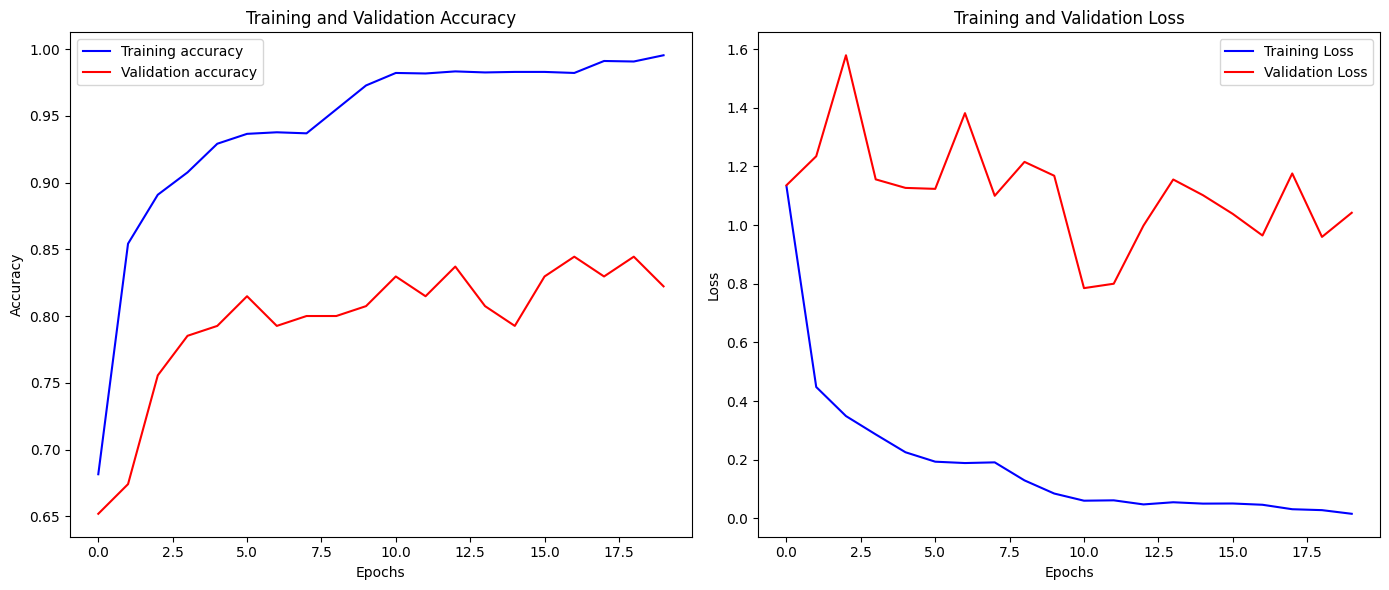

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(14, 6))

# Plot Training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
MODEL_SAVE_PATH = "/content/pest_classification_v1.keras"

print(f"Saving model to {MODEL_SAVE_PATH}...")
model.save(MODEL_SAVE_PATH)
print("Model saved successfully.")

Saving model to /content/pest_classification_v1.keras...
Model saved successfully.
